# Mink CNN usage examples

## Imports

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mink import NeuralNetRegressor
from mink.layers import DenseLayer
from mink.layers import InputLayer
from mink.layers import Conv2DLayer
from mink.layers import DropoutLayer
from mink.layers import MaxPool2DLayer
from mink.layers import ImageResizeLayer
from mink.layers import ConcatLayer
from mink.nonlinearities import Softmax
from mink import updates

## Data

In [3]:
df = pd.read_csv('../../data/mnist/train.csv')

In [4]:
y = df.pop('label')

In [5]:
X = (df.values / 255.).astype(np.float32)

In [6]:
X.shape

(42000, 784)

In [7]:
X = X.reshape(-1, 28, 28, 1)

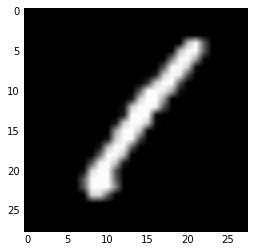

In [8]:
plt.imshow(X[0, :, :, 0], cmap='gray')

In [9]:
X, y = shuffle(X, y)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8)

## Train

In [11]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
session_kwargs = {'config': tf.ConfigProto(gpu_options=gpu_options)}

In [12]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

In [13]:
l_inp = InputLayer(ys=tf.placeholder('float32', shape=(None, 28, 28, 1)))

l_c01 = Conv2DLayer(l_inp, num_filters=32)
l_c02 = Conv2DLayer(l_c01, num_filters=32)
l_p03 = MaxPool2DLayer(l_c02)

l_c11 = Conv2DLayer(l_p03, num_filters=64)
l_c12 = Conv2DLayer(l_c11, num_filters=64)
l_p13 = MaxPool2DLayer(l_c12)

# bottom
l_c20 = Conv2DLayer(l_p13, num_filters=64)
l_c21 = Conv2DLayer(l_c20, num_filters=64)

l_u14 = ImageResizeLayer(l_c21)
l_m15 = ConcatLayer([l_u14, l_c12], axis=3)
l_c16 = Conv2DLayer(l_m15, num_filters=64)
l_c17 = Conv2DLayer(l_c16, num_filters=64)

l_u04 = ImageResizeLayer(l_c17)
l_m05 = ConcatLayer([l_u04, l_c02], axis=3)
l_c06 = Conv2DLayer(l_m05, num_filters=32)
l_c07 = Conv2DLayer(l_c06, num_filters=32)

l_out = Conv2DLayer(l_c07, num_filters=1, filter_size=1, nonlinearity=sigmoid)

In [14]:
all_layers = [l_inp, l_c01, l_c02, l_p03, l_c11, l_c12, l_p13, l_c20, l_c21, l_u14,
              l_m15, l_c16, l_c17, l_u04, l_m05, l_c06, l_c07, l_out]

In [15]:
net = NeuralNetRegressor(
    layer=all_layers, 
    max_epochs=20, 
    verbose=1, 
    update=updates.Adam(4.0),
    session_kwargs=session_kwargs,
)

In [16]:
net.fit(X_train, X_train[:, ::-1])

# Neural Network with 286529 learnable parameters

## Layer information

|   # | name        | size      |
|----:|:------------|:----------|
|   0 | input       | 28x28x1   |
|   1 | conv2d      | 28x28x32  |
|   2 | conv2d      | 28x28x32  |
|   3 | maxpool2d   | 14x14x32  |
|   4 | conv2d      | 14x14x64  |
|   5 | conv2d      | 14x14x64  |
|   6 | maxpool2d   | 7x7x64    |
|   7 | conv2d      | 7x7x64    |
|   8 | conv2d      | 7x7x64    |
|   9 | imageresize | 14x14x64  |
|  10 | concat      | 14x14x128 |
|  11 | conv2d      | 14x14x64  |
|  12 | conv2d      | 14x14x64  |
|  13 | imageresize | 28x28x64  |
|  14 | concat      | 28x28x96  |
|  15 | conv2d      | 28x28x32  |
|  16 | conv2d      | 28x28x32  |
|  17 | conv2d      | 28x28x1   |

|   epoch |   train loss |      dur |
|--------:|-------------:|---------:|
|       1 |      0.07859 | 59.08913 |
|       2 |      0.07034 | 58.83300 |
|       3 |      0.06837 | 58.89903 |
|       4 |      0.06778 | 58.83018 |
|       5 |      0

NeuralNetRegressor(batch_iterator_test=128, batch_iterator_train=128,
          encoder=None,
          layer=[InputLayer(Xs=None, make_logs=False, name=None,
      ys=<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>), Conv2DLayer(W=GlorotUniform(c01b=False, gain=1.0), b=Constant(value=0.0),
      filter_size=3,
      incoming=InputLayer(Xs=None, make_logs=False, name=None,
      ys=<tf....  nonlinearity=<function sigmoid at 0x7fefaec30268>, num_filters=1,
      padding='SAME', stride=1)],
          max_epochs=20, objective=MeanSquaredError(),
          on_epoch_finished=(<mink.handlers.PrintTrainProgress object at 0x7fefaeca5438>,),
          on_training_started=(<mink.handlers.PrintLayerInfo object at 0x7fefaeca5400>,),
          session_kwargs={'config': gpu_options {
  per_process_gpu_memory_fraction: 0.5
}
},
          update=Adam(learning_rate=4.0), verbose=1)

## Validate

In [17]:
%time y_pred = net.predict(X_valid)

CPU times: user 3.7 s, sys: 84 ms, total: 3.79 s
Wall time: 4.35 s


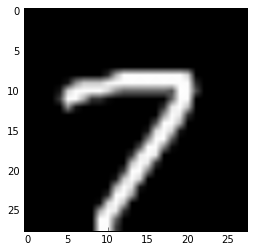

In [18]:
plt.imshow(X_valid[0, :, :, 0], cmap='gray')

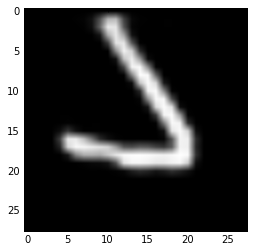

In [19]:
plt.imshow(y_pred[0, :, :, 0], cmap='gray')

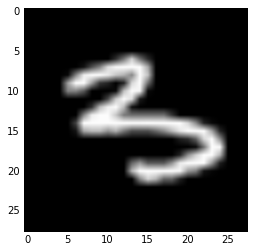

In [20]:
plt.imshow(X_valid[110, :, :, 0], cmap='gray')

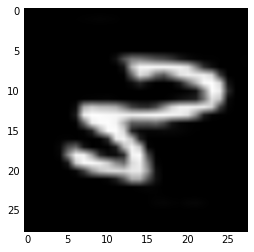

In [21]:
plt.imshow(y_pred[110, :, :, 0], cmap='gray')